# Preparing the Data for Modeling

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter
from sentence_transformers import SentenceTransformer

# Plot Config

In [ ]:
# Custom purple color palette
purple_palette = ['#9b59b6', '#AF7AC5', '#C39BD3', '#D7BDE2', '#E8DAEF']  

# Darker purple palette
dark_purple_palette = ['#6A0DAD', '#8E44AD', '#9B59B6', '#B19CD9', '#D2B4DE']

# More vibrant purple palette
vibrant_purple_palette = ['#4A148C', '#6A1B9A', '#8E24AA', '#AB47BC', '#CE93D8']

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

## Unbiased Dataset

> Loading the dataset and dropping useless columns

In [2]:
unbiased = pd.read_csv("../data/all_data.csv")
unbiased = unbiased.drop(columns=['id','split', 'created_date', 'publication_id',
       'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes',
       'disagree', 'identity_annotator_count',
       'toxicity_annotator_count'])

> Dealing with missing values

In [3]:
demographic_cols = [
    'male', 'female', 'transgender', 'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
    'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
    'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
    'latino', 'other_race_or_ethnicity', 'physical_disability',
    'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
    'other_disability'
]
unbiased[demographic_cols] = unbiased[demographic_cols].fillna(0)
unbiased['comment_text'] = unbiased['comment_text'].fillna('')

## Wikipedia Dataset

In [4]:
wikipedia = pd.read_csv('../data/wikipedia_data/train.csv')

In [5]:
wikipedia = wikipedia.drop(columns=['id'])

In [6]:
wikipedia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


# Final Dataset

> merging the toxic valeus from wikipedia into the unbiased dataset

In [7]:
unbiased.columns

Index(['comment_text', 'toxicity', 'severe_toxicity', 'obscene',
       'sexual_explicit', 'identity_attack', 'insult', 'threat', 'male',
       'female', 'transgender', 'other_gender', 'heterosexual',
       'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
       'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist',
       'other_religion', 'black', 'white', 'asian', 'latino',
       'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability'],
      dtype='object')

In [8]:
wikipedia.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

> filtering to get only the toxic examples

In [9]:
toxic_mask = (wikipedia[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] >= 0.5).any(axis=1)
wikipedia_toxic_df = wikipedia[toxic_mask]

> fixing any different column names

In [11]:
column_mapping = {
    'comment_text': 'comment_text',
    'toxic': 'toxicity',
    'severe_toxic': 'severe_toxicity',
    'obscene': 'obscene',
    'threat': 'threat',
    'insult': 'insult',
    'identity_hate': 'identity_attack'
}
wikipedia_mapped_df = wikipedia_toxic_df[column_mapping.keys()].rename(columns=column_mapping)

> dealing with the missing columns

In [12]:
missing_columns = set(unbiased.columns) - set(wikipedia_mapped_df.columns)
for col in missing_columns:
    wikipedia_mapped_df[col] = 0

wikipedia_mapped_df = wikipedia_mapped_df.reindex(columns=unbiased.columns, fill_value=0)

> combining and saving the result

In [13]:
merged_df = pd.concat([unbiased, wikipedia_mapped_df], ignore_index=True)

# Save the merged dataset
merged_df.to_csv('../data/merged_data/merged_dataset.csv', index=False)

# Merged Dataset

In [ ]:
df = pd.read_csv('../data/merged_data/merged_dataset.csv')
categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
              'identity_attack', 'insult', 'threat']

In [15]:
print(f"Data loaded with shape: {df.shape}")
print(f"Target categories: {categories}")

X = df['comment_text']  
y = df[categories]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['toxicity'] >= 0.5
)

Data loaded with shape: (2015741, 32)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


> Ploting the new Distribuition of Toxic Labels

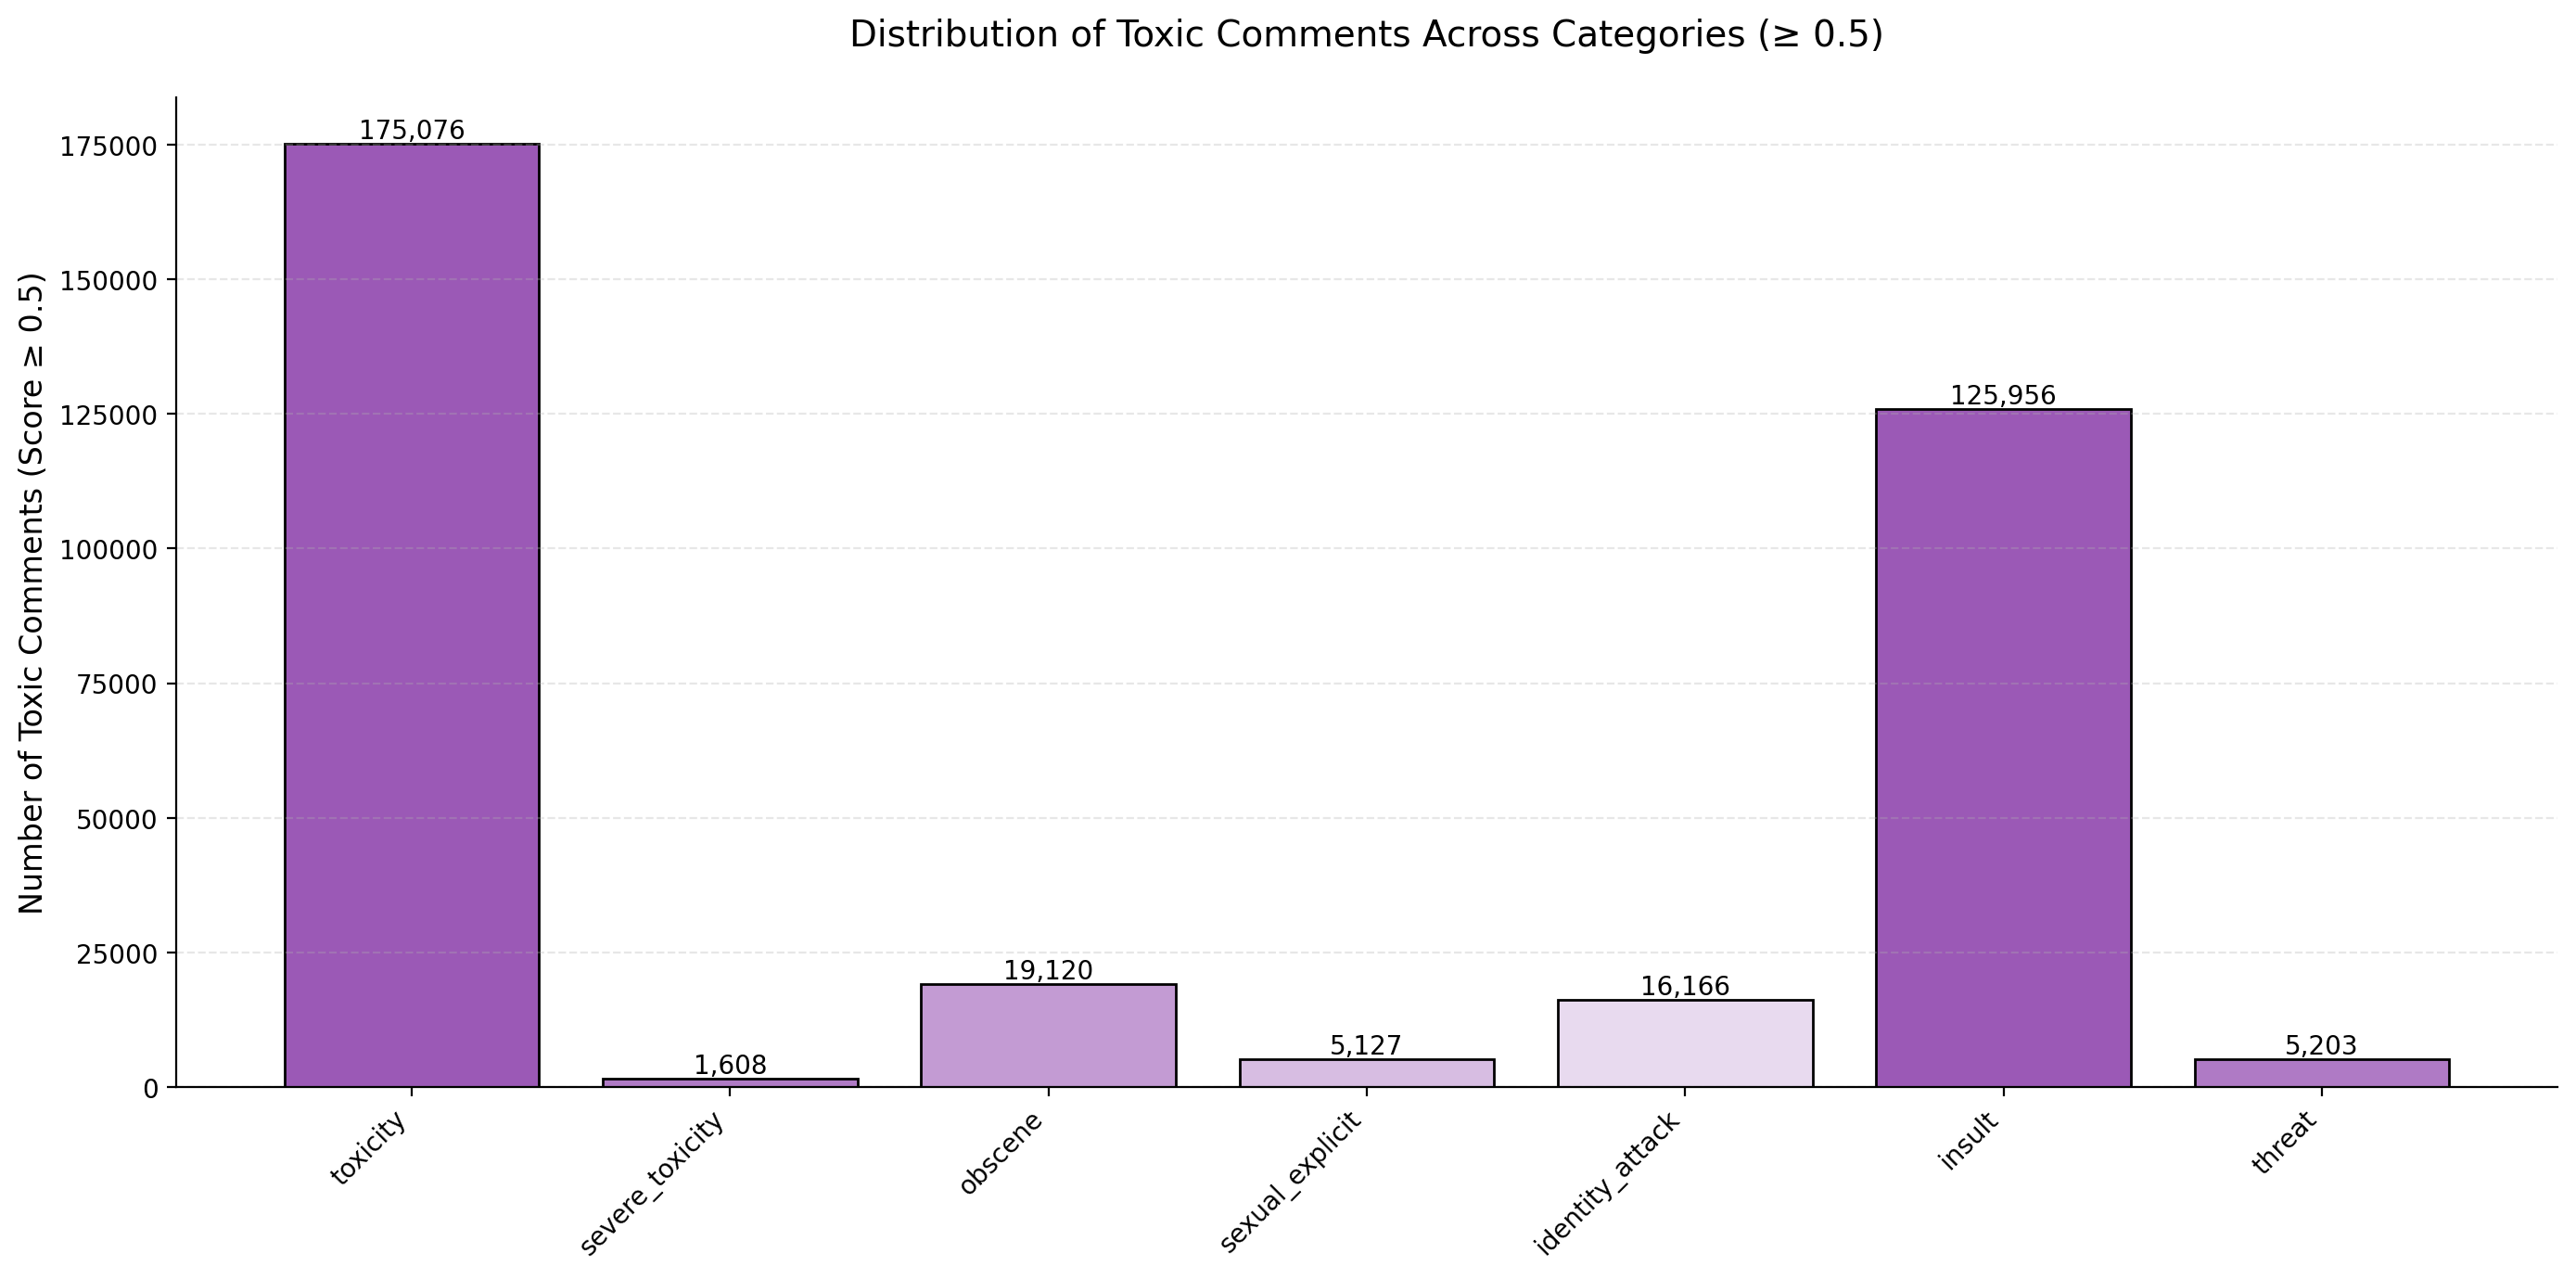

In [17]:
toxic_counts = {}
for category in categories:
    toxic_counts[category] = (df[category] >= 0.5).sum()

# Create a color gradient
n_categories = len(categories)
colors = [purple_palette[i % len(purple_palette)] for i in range(n_categories)]

# Create bar plot
plt.figure(figsize=(14, 7))
bars = plt.bar(range(len(toxic_counts)), list(toxic_counts.values()), color=colors, edgecolor='black')

# Customize the plot
plt.xticks(range(len(toxic_counts)), categories, rotation=45, ha='right')
plt.ylabel('Number of Toxic Comments (Score ≥ 0.5)', fontsize=12)
plt.title('Distribution of Toxic Comments Across Categories (≥ 0.5)', fontsize=14, pad=20)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3, linestyle='--')


plt.tight_layout()
plt.show()


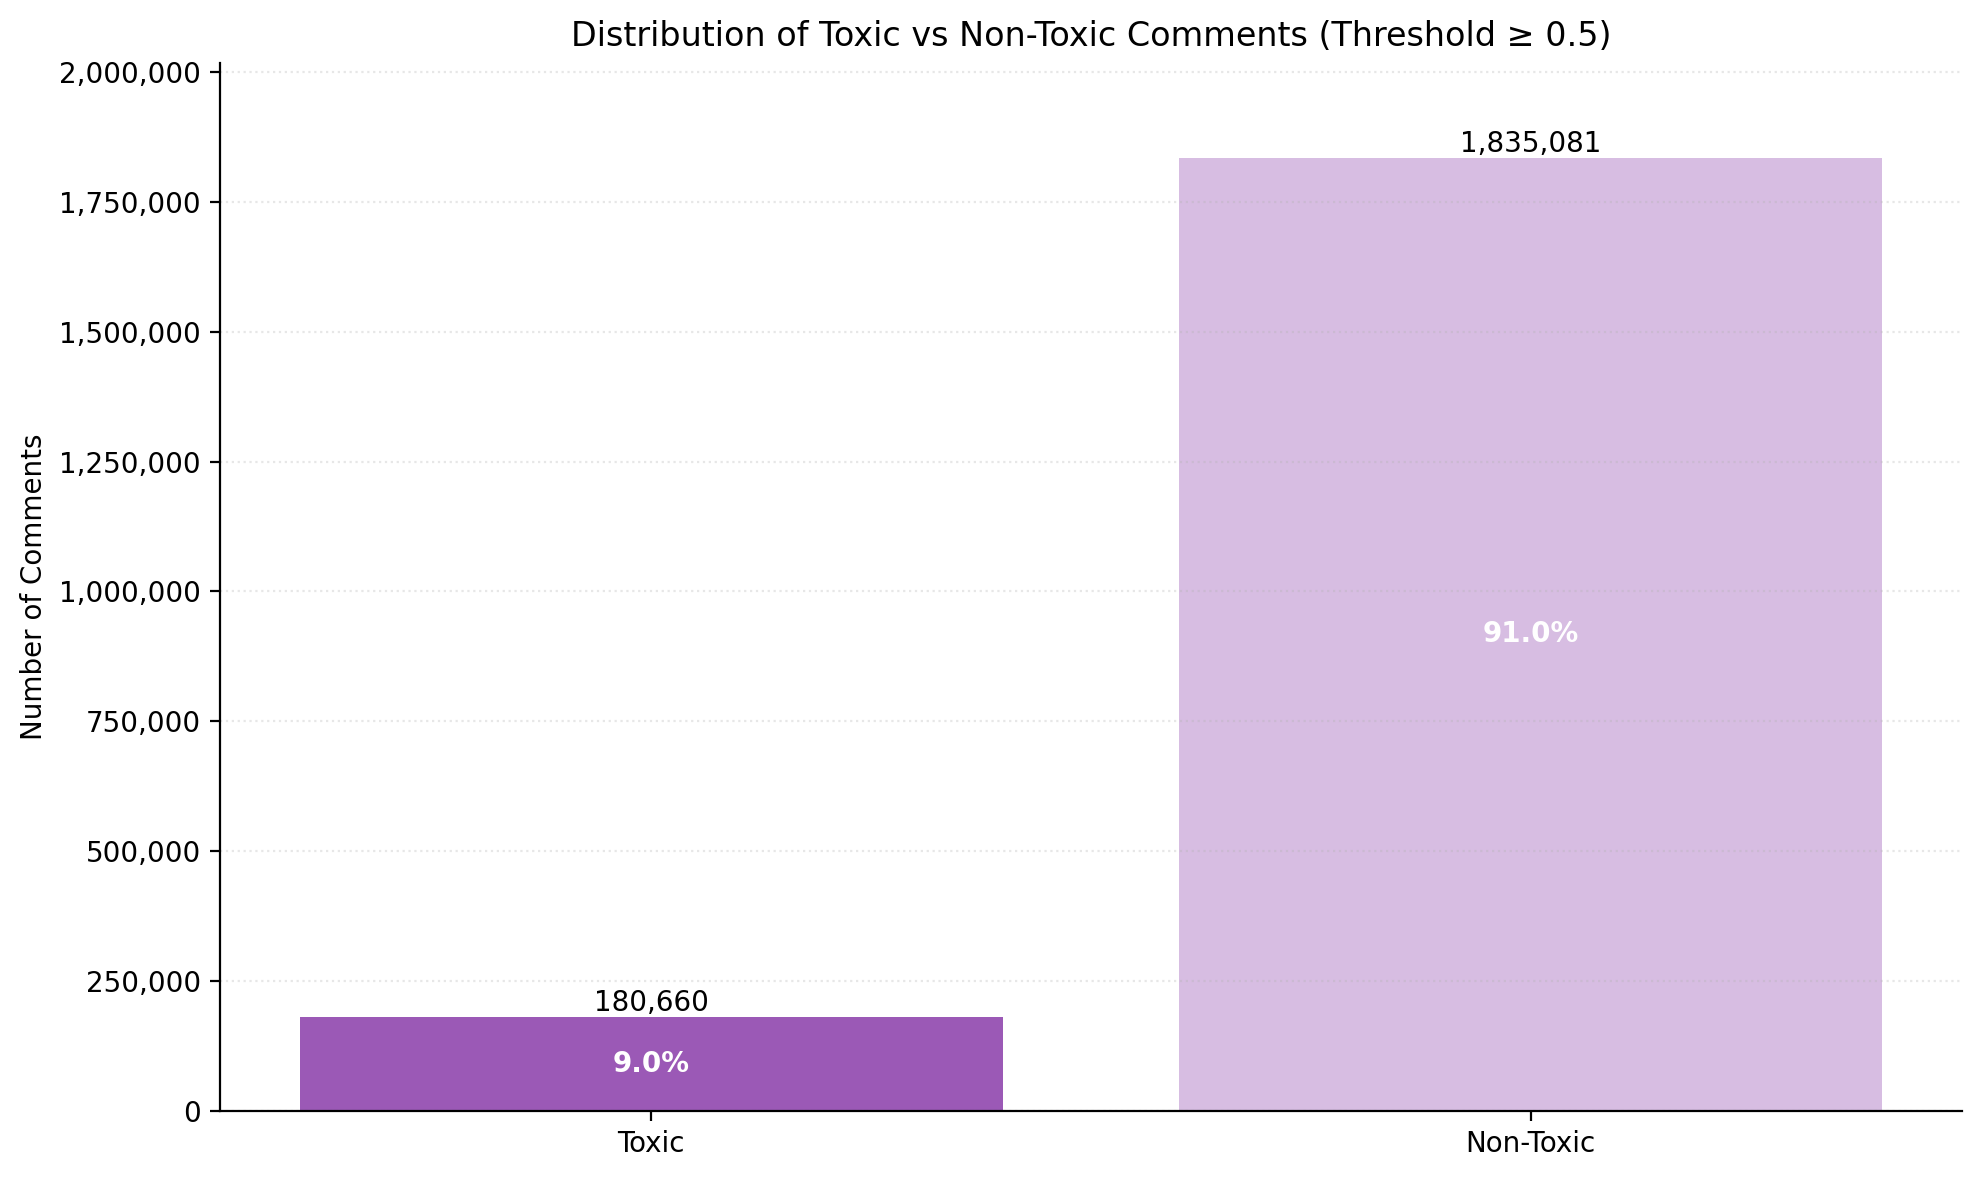

In [18]:
toxic_mask = df[categories].ge(0.5).any(axis=1)
toxic_count = toxic_mask.sum()
non_toxic_count = len(df) - toxic_count

# Create bar plot with better colors
plt.figure(figsize=(10, 6))
bars = plt.bar(['Toxic', 'Non-Toxic'], [toxic_count, non_toxic_count], 
               color=['#9b59b6', '#D7BDE2'])  # Dark purple and light purple

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Add percentage labels inside bars
total = toxic_count + non_toxic_count
for bar in bars:
    percentage = (bar.get_height() / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{percentage:.1f}%',
             ha='center', va='center', color='white', fontweight='bold')

# Improve y-axis formatting
plt.grid(True, axis='y', alpha=0.3)
plt.title('Distribution of Toxic vs Non-Toxic Comments (Threshold ≥ 0.5)')
plt.ylabel('Number of Comments')


plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# Calculate appropriate y-axis limit with some headroom
max_count = max(toxic_count, non_toxic_count)
plt.ylim(0, max_count * 1.1)  # Add 10% headroom

# Add more tick marks for better readability
plt.locator_params(axis='y', nbins=10)

plt.tight_layout()
plt.show()


# Sampling

## Random Undersampling

Original distribution:
toxicity: Positive=175076, Negative=1840665, Ratio=0.0869
severe_toxicity: Positive=1608, Negative=2014133, Ratio=0.0008
obscene: Positive=19120, Negative=1996621, Ratio=0.0095
sexual_explicit: Positive=5127, Negative=2010614, Ratio=0.0025
identity_attack: Positive=16166, Negative=1999575, Ratio=0.0080
insult: Positive=125956, Negative=1889785, Ratio=0.0625
threat: Positive=5203, Negative=2010538, Ratio=0.0026

Balanced distribution:
toxicity: Positive=175017, Negative=325341, Ratio=0.3498
severe_toxicity: Positive=1608, Negative=498750, Ratio=0.0032
obscene: Positive=19119, Negative=481239, Ratio=0.0382
sexual_explicit: Positive=5127, Negative=495231, Ratio=0.0102
identity_attack: Positive=16165, Negative=484193, Ratio=0.0323
insult: Positive=125902, Negative=374456, Ratio=0.2516
threat: Positive=5203, Negative=495155, Ratio=0.0104
Perfect balance (1.0) dataset size: 500358
Original distribution:
toxicity: Positive=175076, Negative=1840665, Ratio=0.0869
severe_t

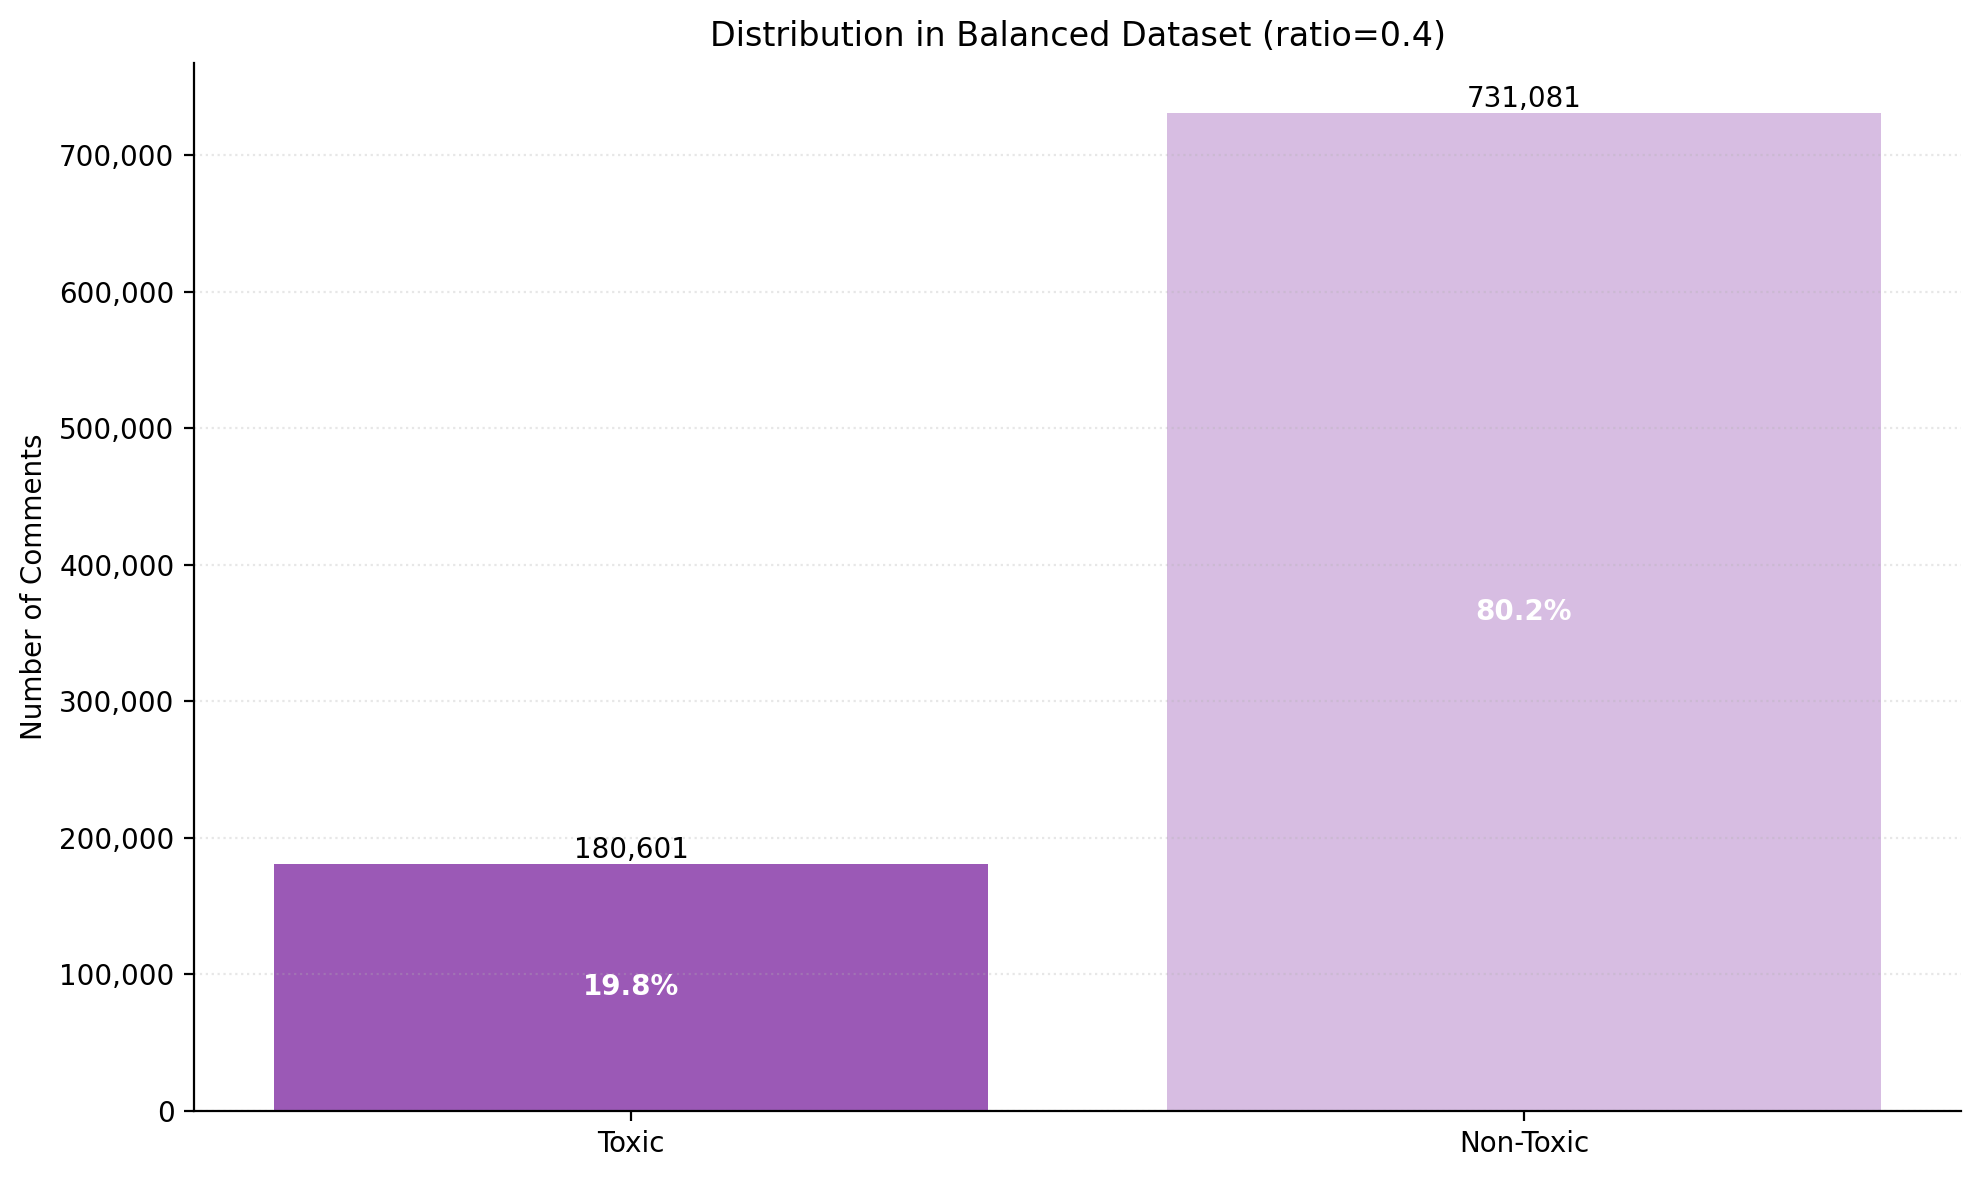

In [ ]:
# Function to balance the dataset with a controllable ratio
def undersample_multilabel_dataset(df, categories, balance_ratio=1.0, random_state=42):
    # First, check the current distribution for each category
    print("Original distribution:")
    for category in categories:
        pos_count = (df[category] >= 0.5).sum()
        neg_count = len(df) - pos_count
        ratio = pos_count / len(df)
        print(f"{category}: Positive={pos_count}, Negative={neg_count}, Ratio={ratio:.4f}")
    
    # If balance_ratio is 0, return the original dataset
    if balance_ratio == 0:
        return df
    
    # Create a list to store balanced samples for each category
    balanced_samples = []
    
    # Process each label separately
    for category in categories:
        # Get positive and negative samples for this category
        positive_samples = df[df[category] >= 0.5]
        negative_samples = df[df[category] < 0.5]
        
        # Get counts
        pos_count = len(positive_samples)
        neg_count = len(negative_samples)
        
        # Determine which class is the minority
        is_pos_minority = pos_count < neg_count
        
        if is_pos_minority:
            # Positive class is minority
            minority_size = pos_count
            majority_size = neg_count
            minority_samples = positive_samples
            majority_samples = negative_samples
        else:
            # Negative class is minority
            minority_size = neg_count
            majority_size = pos_count
            minority_samples = negative_samples
            majority_samples = positive_samples
        
        # Calculate target size for majority class based on balance_ratio
        # balance_ratio=1.0 means equal sizes (perfect balance)
        # balance_ratio=0.5 means majority class will be twice the size of minority
        # balance_ratio=0.25 means majority class will be four times the size of minority
        if balance_ratio >= 1.0:
            # Keep all minority samples and downsample majority to match
            target_majority_size = minority_size
        else:
            # Allow majority class to be larger based on the ratio
            target_majority_size = int(minority_size / balance_ratio)
            # Make sure we don't exceed the original majority size
            target_majority_size = min(target_majority_size, majority_size)
        
        # Sample from majority class
        sampled_majority = majority_samples.sample(target_majority_size, random_state=random_state)
        
        # Combine the samples for this category
        category_balanced = pd.concat([minority_samples, sampled_majority])
        balanced_samples.append(category_balanced)
    
    # Combine all balanced samples and remove duplicates
    balanced_df = pd.concat(balanced_samples).drop_duplicates()
    
    # Check the distribution in the balanced dataset
    print("\nBalanced distribution:")
    for category in categories:
        pos_count = (balanced_df[category] >= 0.5).sum()
        neg_count = len(balanced_df) - pos_count
        ratio = pos_count / len(balanced_df)
        print(f"{category}: Positive={pos_count}, Negative={neg_count}, Ratio={ratio:.4f}")
    
    return balanced_df


### Applying Undersampling and Plotting new Dataset

In [ ]:
# Examples:
# balance_ratio=1.0 (default): Perfect balance (equal positive and negative)
# balance_ratio=0.5: Majority class will be twice the size of minority
# balance_ratio=0.25: Majority class will be four times the size of minority
# balance_ratio=0.1: Majority class will be ten times the size of minority


balanced_df_light = undersample_multilabel_dataset(df, categories, balance_ratio=0.40)
print(f"Light balance (0.25) dataset size: {len(balanced_df_light)}")

# Choose the balanced dataset 
balanced_df = balanced_df_light  

# Visualize the distribution
toxic_mask_balanced = balanced_df[categories].ge(0.5).any(axis=1)
toxic_count_balanced = toxic_mask_balanced.sum()
non_toxic_count_balanced = len(balanced_df) - toxic_count_balanced

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(['Toxic', 'Non-Toxic'], [toxic_count_balanced, non_toxic_count_balanced], 
               color=['#9b59b6', '#D7BDE2'])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Add percentage labels inside bars
total_balanced = toxic_count_balanced + non_toxic_count_balanced
for bar in bars:
    percentage = (bar.get_height() / total_balanced) * 100
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{percentage:.1f}%',
             ha='center', va='center', color='white', fontweight='bold')

plt.grid(True, axis='y', alpha=0.3)
plt.title(f'Distribution in Balanced Dataset (ratio={0.40})')
plt.ylabel('Number of Comments')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

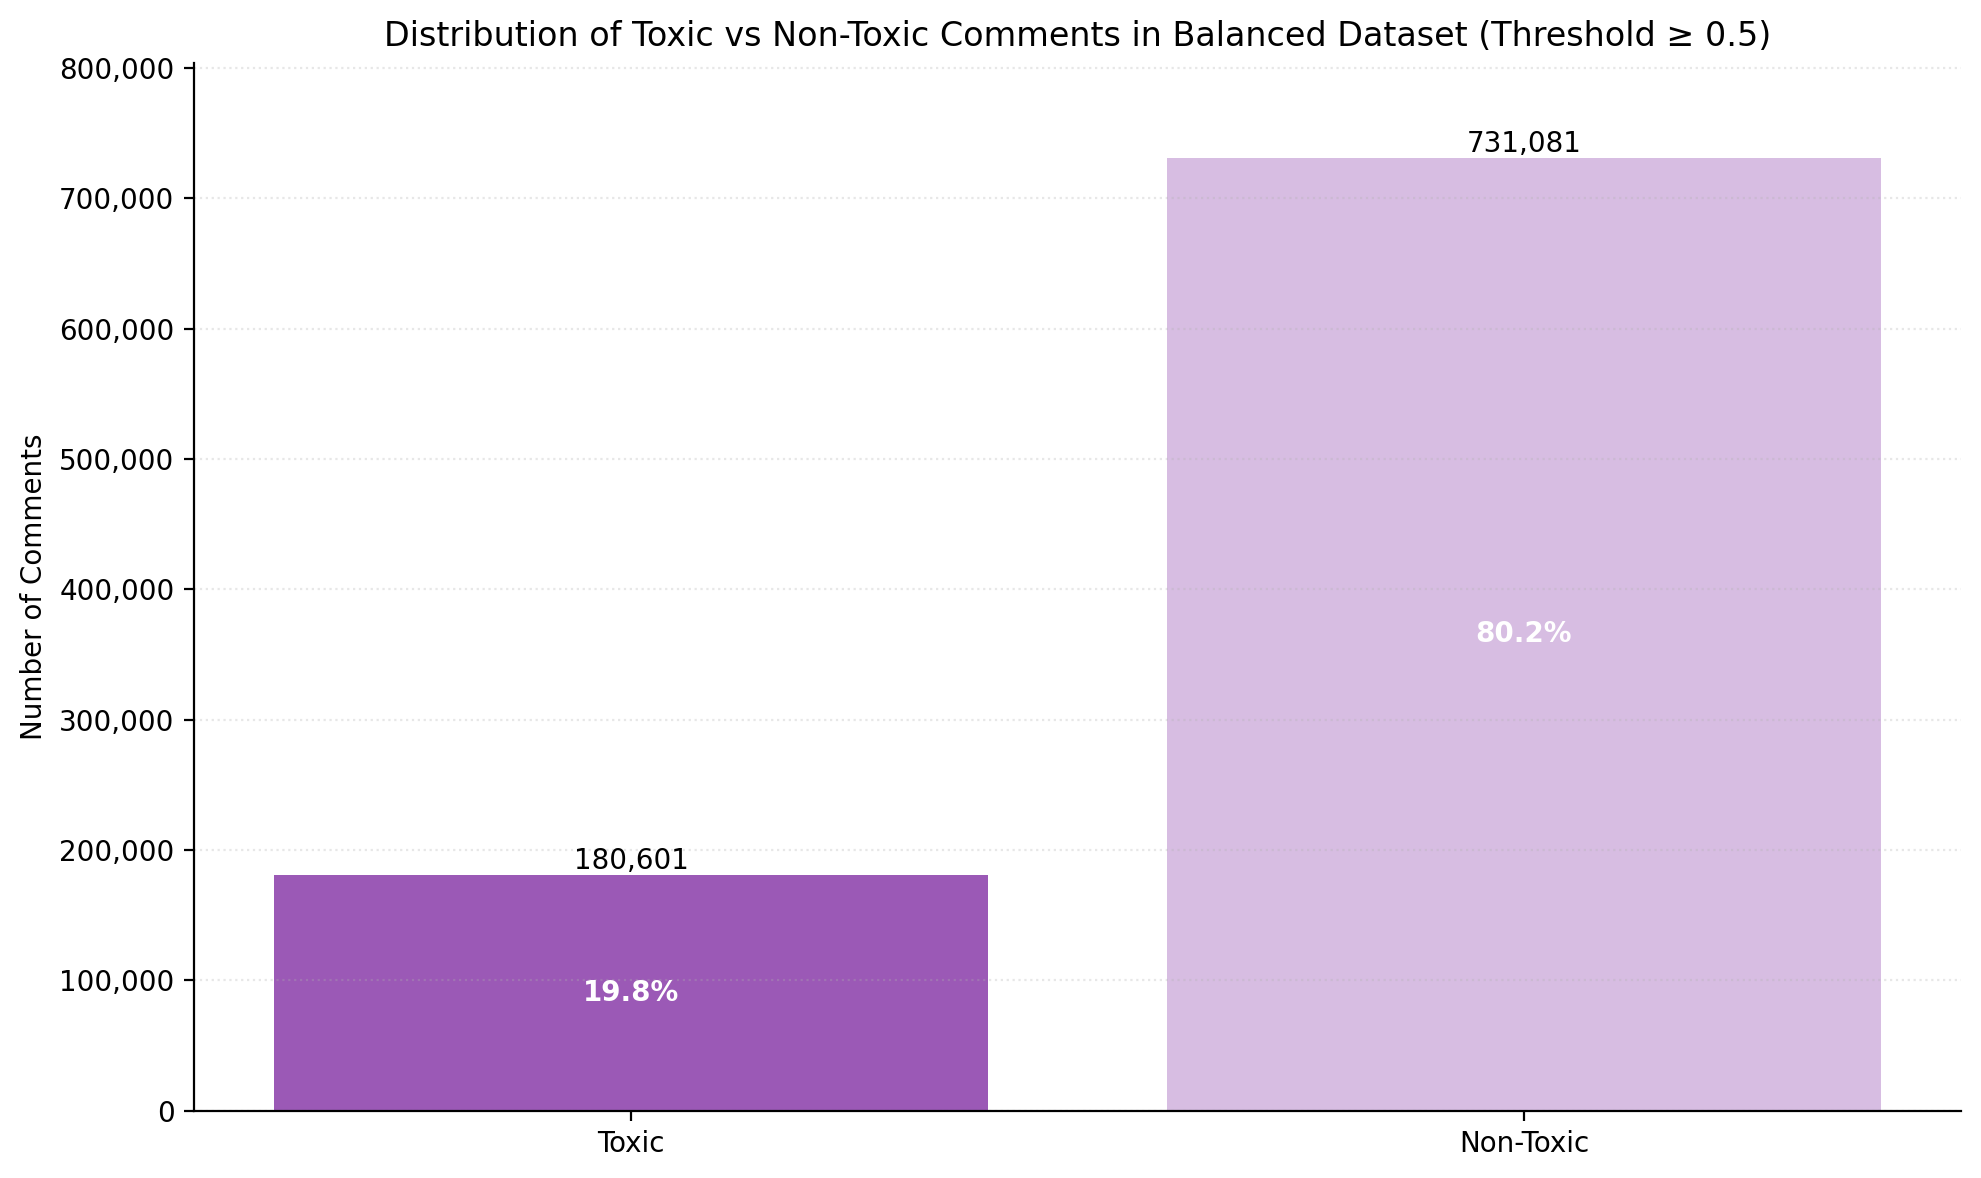

In [21]:
toxic_mask_balanced = balanced_df[categories].ge(0.5).any(axis=1)
toxic_count_balanced = toxic_mask_balanced.sum()
non_toxic_count_balanced = len(balanced_df) - toxic_count_balanced

# Create bar plot with better colors
plt.figure(figsize=(10, 6))
bars = plt.bar(['Toxic', 'Non-Toxic'], [toxic_count_balanced, non_toxic_count_balanced], 
               color=['#9b59b6', '#D7BDE2'])  # Dark purple and light purple

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Add percentage labels inside bars
total_balanced = toxic_count_balanced + non_toxic_count_balanced
for bar in bars:
    percentage = (bar.get_height() / total_balanced) * 100
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{percentage:.1f}%',
             ha='center', va='center', color='white', fontweight='bold')

# Improve y-axis formatting
plt.grid(True, axis='y', alpha=0.3)
plt.title('Distribution of Toxic vs Non-Toxic Comments in Balanced Dataset (Threshold ≥ 0.5)')
plt.ylabel('Number of Comments')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# Calculate appropriate y-axis limit with some headroom
max_count_balanced = max(toxic_count_balanced, non_toxic_count_balanced)
plt.ylim(0, max_count_balanced * 1.1)  # Add 10% headroom

# Add more tick marks for better readability
plt.locator_params(axis='y', nbins=10)

plt.tight_layout()
plt.show()


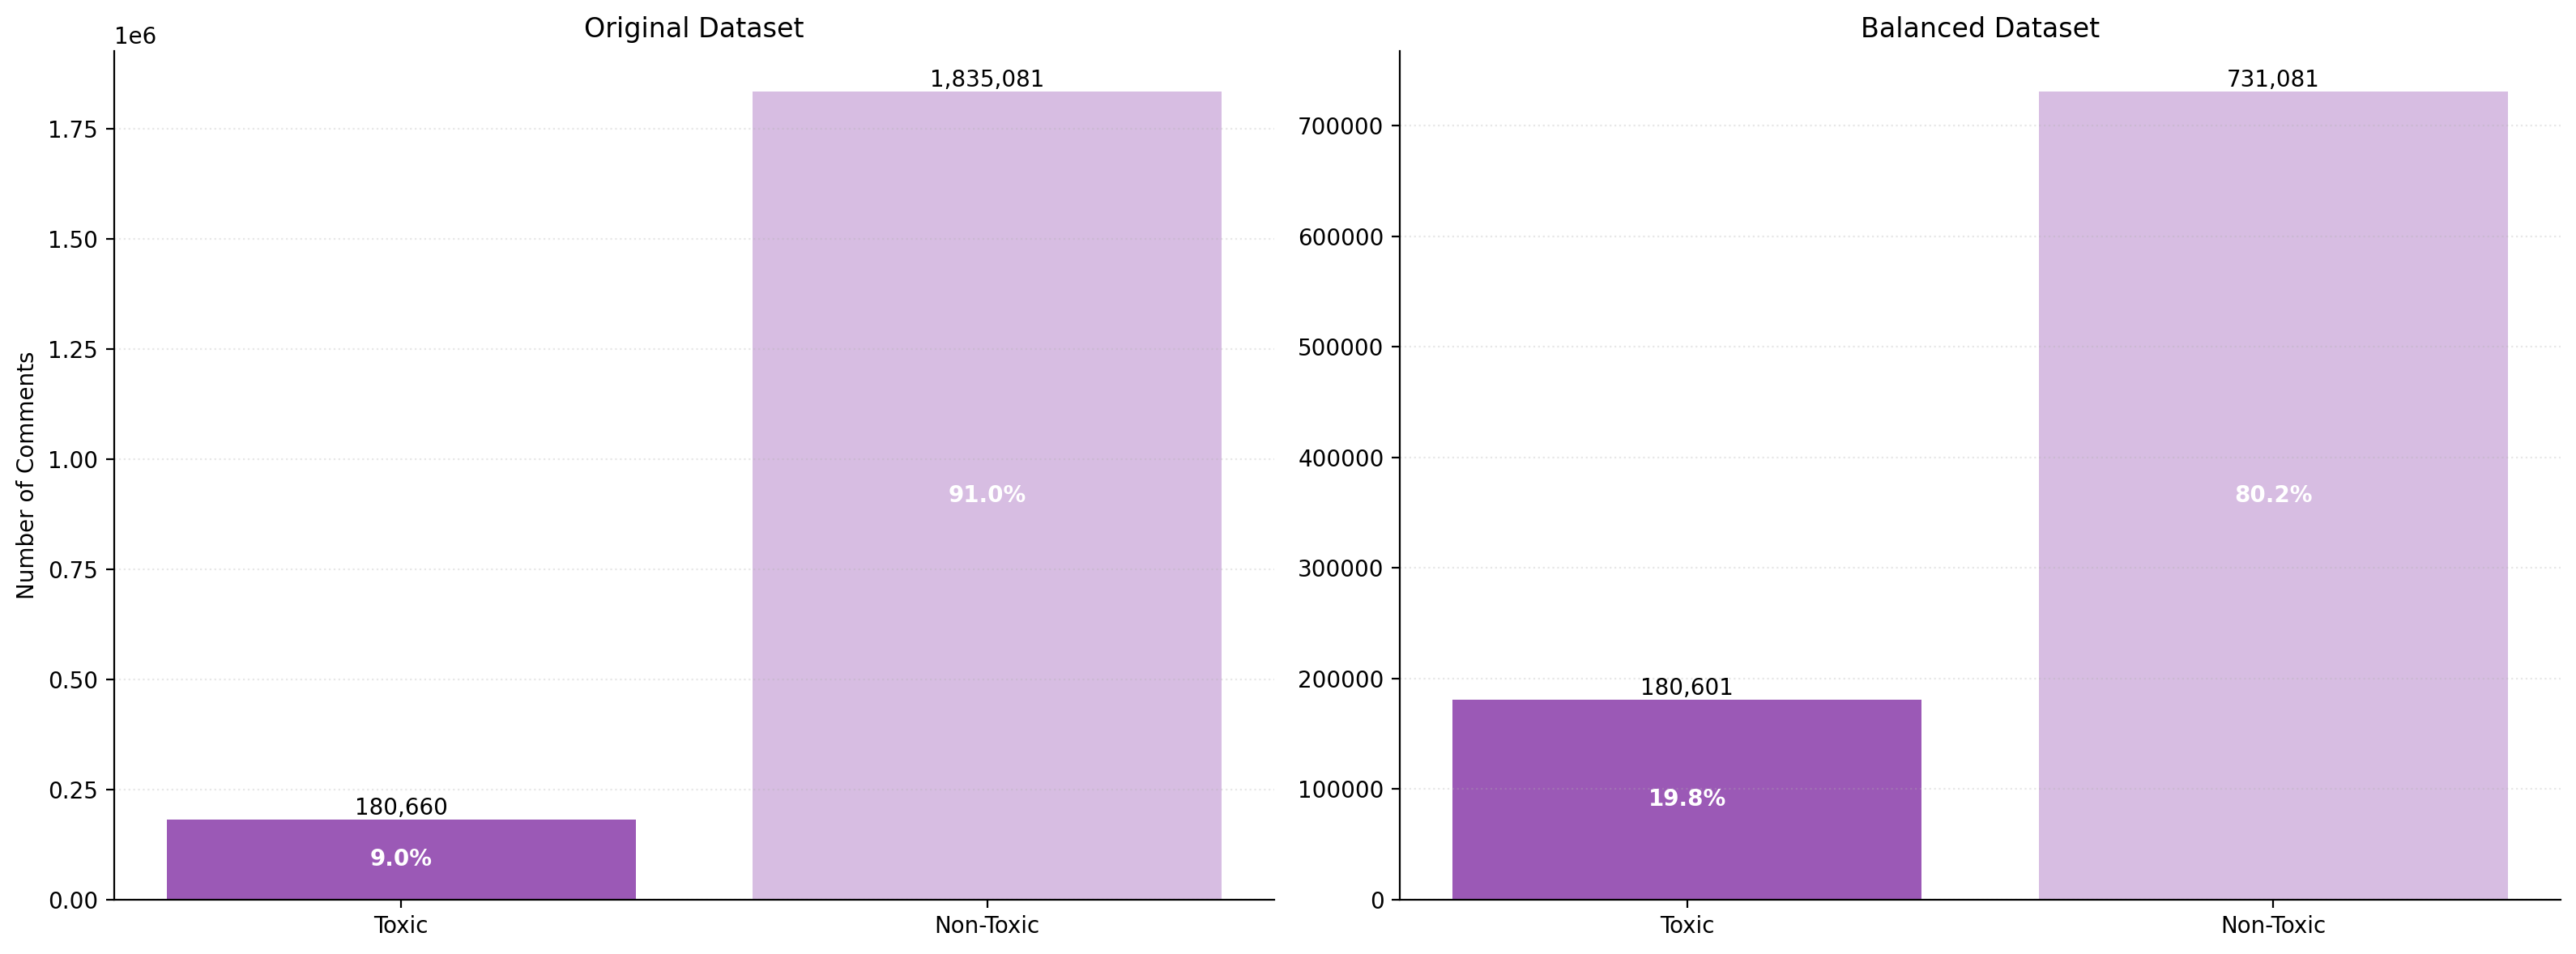

In [21]:
# Create a comparison bar chart
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Original data distribution
original_data = [toxic_count, non_toxic_count]
ax[0].bar(['Toxic', 'Non-Toxic'], original_data, color=['#9b59b6', '#D7BDE2'])
ax[0].set_title('Original Dataset')
ax[0].set_ylabel('Number of Comments')
ax[0].grid(True, axis='y', alpha=0.3)

# Add percentage labels
total_original = sum(original_data)
for i, v in enumerate(original_data):
    percentage = (v / total_original) * 100
    ax[0].text(i, v/2, f'{percentage:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    ax[0].text(i, v, f'{int(v):,}', ha='center', va='bottom')

# Balanced data distribution
balanced_data = [toxic_count_balanced, non_toxic_count_balanced]
ax[1].bar(['Toxic', 'Non-Toxic'], balanced_data, color=['#9b59b6', '#D7BDE2'])
ax[1].set_title('Balanced Dataset')
ax[1].grid(True, axis='y', alpha=0.3)

# Add percentage labels
total_balanced = sum(balanced_data)
for i, v in enumerate(balanced_data):
    percentage = (v / total_balanced) * 100
    ax[1].text(i, v/2, f'{percentage:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    ax[1].text(i, v, f'{int(v):,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


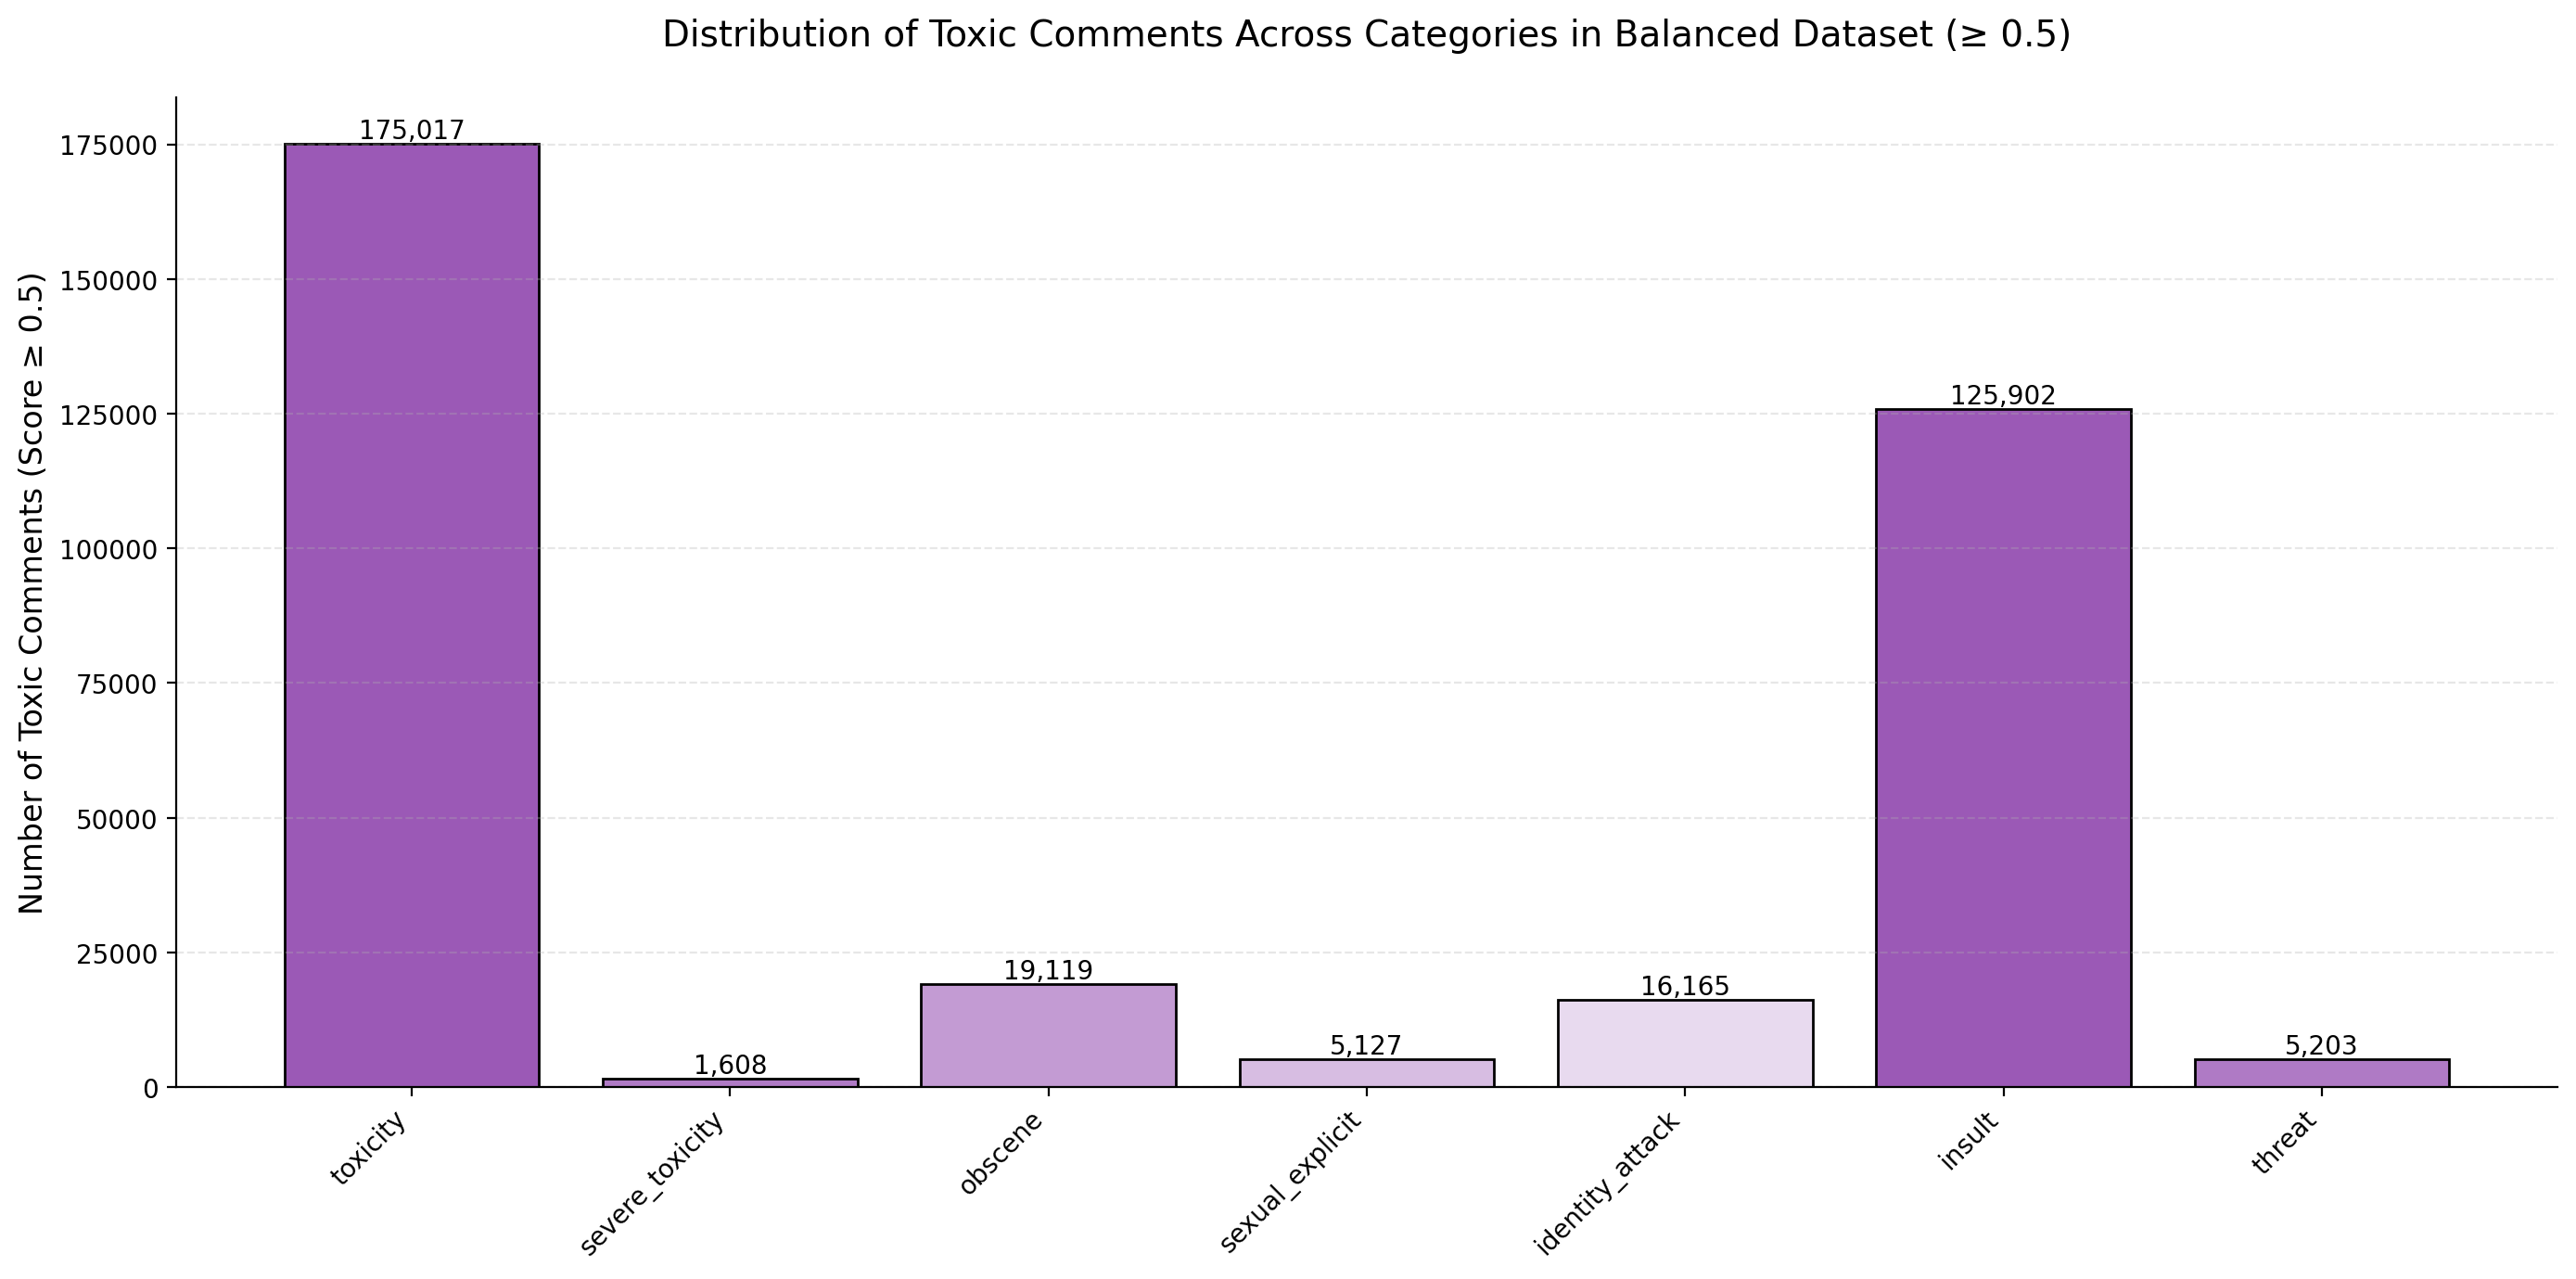

In [22]:
# Calculate counts for each category in the balanced dataset
balanced_toxic_counts = {}
for category in categories:
    balanced_toxic_counts[category] = (balanced_df[category] >= 0.5).sum()
    
# Create bar plot
plt.figure(figsize=(14, 7))
bars = plt.bar(range(len(balanced_toxic_counts)), list(balanced_toxic_counts.values()), 
               color=[purple_palette[i % len(purple_palette)] for i in range(len(categories))], 
               edgecolor='black')

# Customize the plot
plt.xticks(range(len(balanced_toxic_counts)), categories, rotation=45, ha='right')
plt.ylabel('Number of Toxic Comments (Score ≥ 0.5)', fontsize=12)
plt.title('Distribution of Toxic Comments Across Categories in Balanced Dataset (≥ 0.5)', fontsize=14, pad=20)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


In [23]:
balanced_df.to_csv('../data/merged_data/undersampled_dataset.csv', index=False)

## Oversampling

In [34]:
balanced_df = pd.read_csv('../data/merged_data/undersampled_dataset.csv')

### MLSMOTE Implementation

reference for the following MLSMOTE implementation: https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87

In [35]:
# -*- coding: utf-8 -*-
# Importing required Library
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

  

In [36]:
def improved_MLSMOTE(X, y, n_sample):
    """
    MLSMOTE implementation that prioritizes rare toxicity categories
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    
    # Get counts for each category to identify the rarest ones
    category_counts = {}
    for col in y.columns:
        category_counts[col] = (y[col] >= 0.5).sum()
    
    # Sort categories by count to identify the rarest ones
    sorted_categories = sorted(category_counts.items(), key=lambda x: x[1])
    
    # The rarest categories (bottom 3-4 categories)
    rarest_categories = [cat[0] for cat in sorted_categories[:4]]
    
    # Get column indices for each category type
    rarest_indices = [y.columns.get_loc(col) for col in rarest_categories]
    
    print(f"Prioritizing these rare categories: {rarest_categories}")
    
    for i in range(n_sample):
        # Prioritize examples with rare categories
        if i % 3 == 0 and len(rarest_indices) > 0:  # Every 3rd example, specifically target rare categories
            # Find examples that have at least one of the rare categories
            rare_examples = []
            for idx in range(len(y)):
                if any(y.iloc[idx, rare_idx] >= 0.5 for rare_idx in rarest_indices):
                    rare_examples.append(idx)
            
            if rare_examples:
                reference = random.choice(rare_examples)
                # Get neighbors of this rare example
                all_point = indices2[reference]
            else:
                # Fallback if no rare examples found
                reference = random.randint(0, n-1)
                all_point = indices2[reference]
        else:
            # Regular sampling for other examples
            reference = random.randint(0, n-1)
            all_point = indices2[reference]
        
        neighbour = random.choice(indices2[reference, 1:])
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis=0, skipna=True)
        
        # Modified approach for target assignment with special focus on rare categories
        target_array = np.zeros(y.shape[1])
        for j, val in enumerate(ser):
            col_name = y.columns[j]
            
            # Special handling for the rarest categories - use very low threshold
            if col_name in rarest_categories:
                # Even a single occurrence is enough for rare categories
                target_array[j] = 1 if val >= 1 else 0
            # Regular minority classes
            elif col_name != 'toxicity':  # Not the majority toxic class
                target_array[j] = 1 if val >= 2 else 0
            else:  # For the majority 'toxicity' class
                target_array[j] = 1 if val > 2 else 0
        
        target[i] = target_array
        
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    
    # Print statistics about generated examples
    print("\nStatistics for generated examples:")
    for col in y.columns:
        count = (target[col] >= 0.5).sum()
        print(f"{col}: {count} positive examples ({count/len(target)*100:.2f}%)")
    
    # Combine with original data
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    
    return new_X, target


In [37]:
def force_rare_categories_MLSMOTE(X, y, n_sample):
    """
    MLSMOTE implementation that forces generation of examples for rare categories
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    
    # Get counts for each category
    category_counts = {}
    for col in y.columns:
        category_counts[col] = (y[col] >= 0.5).sum()
    
    print("Original category distribution:")
    for col, count in category_counts.items():
        print(f"{col}: {count} examples ({count/len(y)*100:.2f}%)")
    
    # Identify the rarest categories (those with very few examples)
    rarest_categories = ['severe_toxicity', 'threat', 'identity_attack']
    
    # Find examples for each rare category
    rare_category_examples = {}
    for cat in rarest_categories:
        # Get indices of examples that have this rare category
        examples = y[y[cat] >= 0.5].index.tolist()
        rare_category_examples[cat] = examples
        print(f"Found {len(examples)} examples for {cat}")
    
    # Allocate portions of synthetic examples to each category
    # Ensure at least 20% of examples for each rare category
    allocation = {
        'severe_toxicity': int(n_sample * 0.25),
        'threat': int(n_sample * 0.25),
        'identity_attack': int(n_sample * 0.25),
        'general': n_sample - int(n_sample * 0.75)  # Remaining examples
    }
    
    current_index = 0
    
    # Generate examples for each rare category
    for cat, num_examples in allocation.items():
        if cat == 'general':
            # Generate general examples with the remaining allocation
            for i in range(current_index, current_index + num_examples):
                reference = random.randint(0, n-1)
                neighbour = random.choice(indices2[reference, 1:])
                all_point = indices2[reference]
                nn_df = y[y.index.isin(all_point)]
                ser = nn_df.sum(axis=0, skipna=True)
                
                # Standard approach for general examples
                target_array = np.zeros(y.shape[1])
                for j, val in enumerate(ser):
                    target_array[j] = 1 if val > 1 else 0
                
                target[i] = target_array
                
                ratio = random.random()
                gap = X.loc[reference,:] - X.loc[neighbour,:]
                new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
        else:
            # Generate examples specifically for this rare category
            examples = rare_category_examples[cat]
            
            # If we have examples of this category, use them as reference
            if examples:
                for i in range(current_index, current_index + num_examples):
                    # Select a random example that has this rare category
                    ref_idx = random.choice(examples)
                    reference = X.index.get_loc(ref_idx)
                    
                    # Get its neighbors
                    if reference < len(indices2):
                        neighbour = random.choice(indices2[reference, 1:])
                        all_point = indices2[reference]
                    else:
                        # Fallback if reference is out of bounds
                        reference = random.randint(0, n-1)
                        neighbour = random.choice(indices2[reference, 1:])
                        all_point = indices2[reference]
                    
                    nn_df = y[y.index.isin(all_point)]
                    ser = nn_df.sum(axis=0, skipna=True)
                    
                    # Create target array - FORCE this category to be positive
                    target_array = np.zeros(y.shape[1])
                    for j, val in enumerate(ser):
                        col_name = y.columns[j]
                        if col_name == cat:
                            target_array[j] = 1  # Force this category to be positive
                        else:
                            target_array[j] = 1 if val > 1 else 0
                    
                    target[i] = target_array
                    
                    ratio = random.random()
                    gap = X.loc[reference,:] - X.loc[neighbour,:]
                    new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
            else:
                # If no examples exist, create synthetic ones by modifying existing examples
                for i in range(current_index, current_index + num_examples):
                    # Select any example as reference
                    reference = random.randint(0, n-1)
                    neighbour = random.choice(indices2[reference, 1:])
                    
                    # Create target array - FORCE this category to be positive
                    target_array = np.zeros(y.shape[1])
                    target_array[y.columns.get_loc(cat)] = 1  # Force this category to be positive
                    target_array[y.columns.get_loc('toxicity')] = 1  # Also mark as toxic
                    
                    # Randomly add some other toxic attributes
                    for other_cat in ['obscene', 'insult']:
                        if random.random() > 0.5:
                            target_array[y.columns.get_loc(other_cat)] = 1
                    
                    target[i] = target_array
                    
                    ratio = random.random()
                    gap = X.loc[reference,:] - X.loc[neighbour,:]
                    new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
        
        current_index += num_examples
    
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    
    # Print statistics about generated examples
    print("\nStatistics for generated examples:")
    for col in y.columns:
        count = (target[col] >= 0.5).sum()
        print(f"{col}: {count} positive examples ({count/len(target)*100:.2f}%)")
    
    # Combine with original data
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    
    return new_X, target


### Embeddings 

In [ ]:
# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast model (384 dimensions)
# model = SentenceTransformer('all-mpnet-base-v2')  # More accurate model (768 dimensions)

# Original data
X_under = balanced_df['comment_text'].fillna('')
y_under = balanced_df[categories]

# Generate embeddings for all texts
print("Generating embeddings for all texts...")
embeddings = model.encode(X_under.tolist(), show_progress_bar=True)

# Convert embeddings to DataFrame 
X_under_embeddings = pd.DataFrame(embeddings)
X_under_embeddings.index = X_under.index

Generating embeddings for all texts...


Batches:   0%|          | 0/28491 [00:00<?, ?it/s]

### Applying MLSMOTE

In [ ]:
# Get minority instances
X_sub, y_sub = get_minority_instace(X_under_embeddings, y_under)

# Apply MLSMOTE to generate synthetic examples
print("Applying MLSMOTE to generate synthetic examples...")
# X_over, y_over = MLSMOTE(X_sub, y_sub, 100000)
X_over, y_over = force_rare_categories_MLSMOTE(X_sub, y_sub, 10000)

# Now X_over contains embedding vectors for synthetic examples
# and y_over contains their corresponding labels

# For visualization and analysis
combined_labels = pd.concat([y_under, y_over], ignore_index=True)

# Calculate the distribution in the combined dataset
toxic_mask_combined = (combined_labels.ge(0.5).any(axis=1))
toxic_count_combined = toxic_mask_combined.sum()
non_toxic_count_combined = len(combined_labels) - toxic_count_combined

print(f"Original dataset: {len(y_under)} examples ({toxic_mask.sum()} toxic, {len(y_under) - toxic_mask.sum()} non-toxic)")
print(f"Synthetic examples: {len(y_over)} examples ({(y_over.ge(0.5).any(axis=1)).sum()} toxic, {len(y_over) - (y_over.ge(0.5).any(axis=1)).sum()} non-toxic)")
print(f"Combined dataset: {len(combined_labels)} examples ({toxic_count_combined} toxic, {non_toxic_count_combined} non-toxic)")

Applying MLSMOTE to generate synthetic examples...
Original category distribution:
toxicity: 44 examples (97.78%)
severe_toxicity: 0 examples (0.00%)
obscene: 14 examples (31.11%)
sexual_explicit: 45 examples (100.00%)
identity_attack: 1 examples (2.22%)
insult: 4 examples (8.89%)
threat: 0 examples (0.00%)
Found 0 examples for severe_toxicity
Found 0 examples for threat
Found 1 examples for identity_attack

Statistics for generated examples:
toxicity: 10000 positive examples (100.00%)
severe_toxicity: 2500 positive examples (25.00%)
obscene: 3379 positive examples (33.79%)
sexual_explicit: 5000 positive examples (50.00%)
identity_attack: 2500 positive examples (25.00%)
insult: 3180 positive examples (31.80%)
threat: 2500 positive examples (25.00%)
Original dataset: 911682 examples (180601 toxic, 731081 non-toxic)
Synthetic examples: 10045 examples (10045 toxic, 0 non-toxic)
Combined dataset: 921727 examples (190646 toxic, 731081 non-toxic)


### Plotings new Dataset

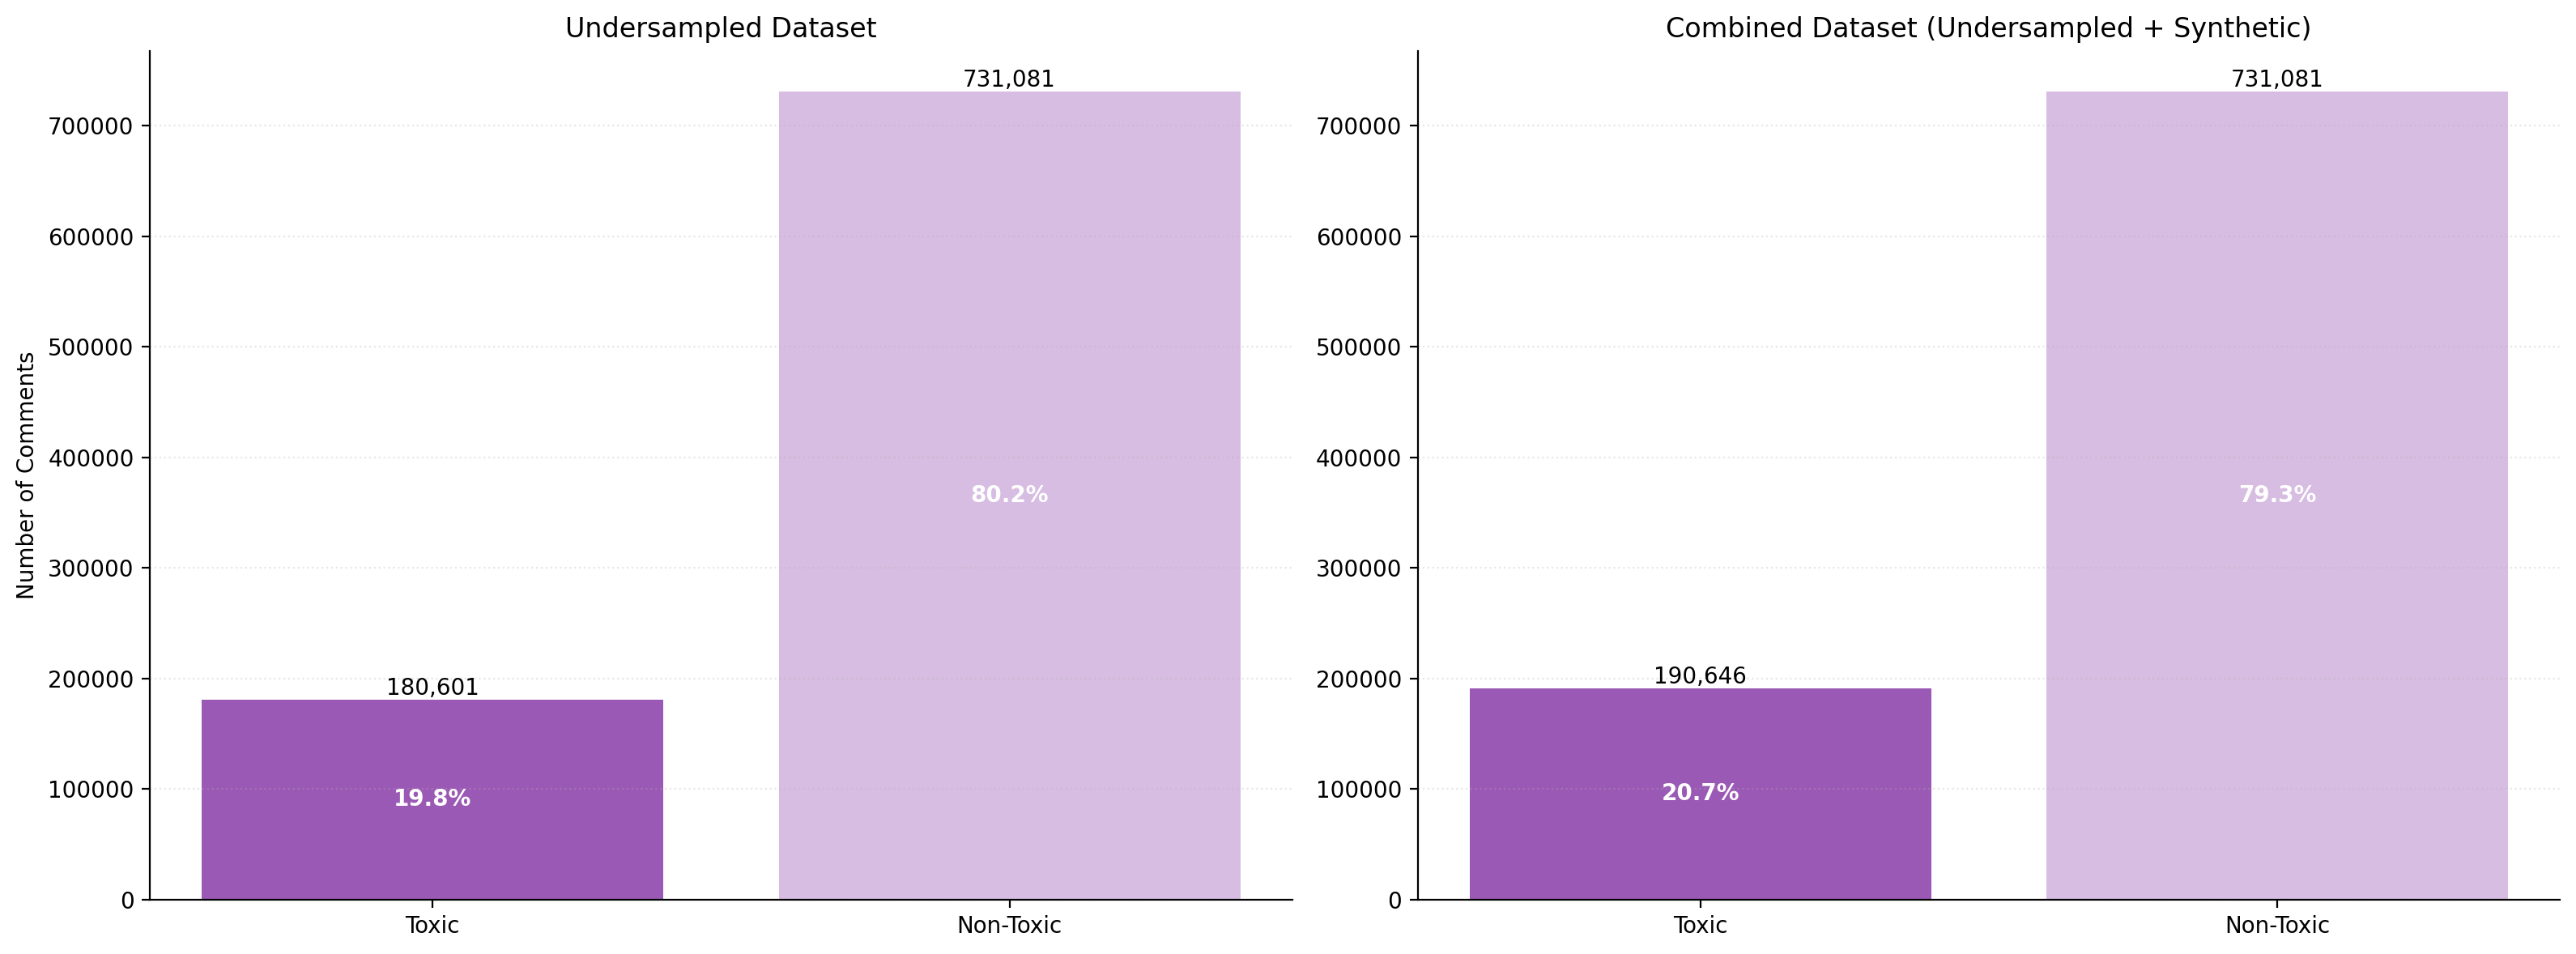

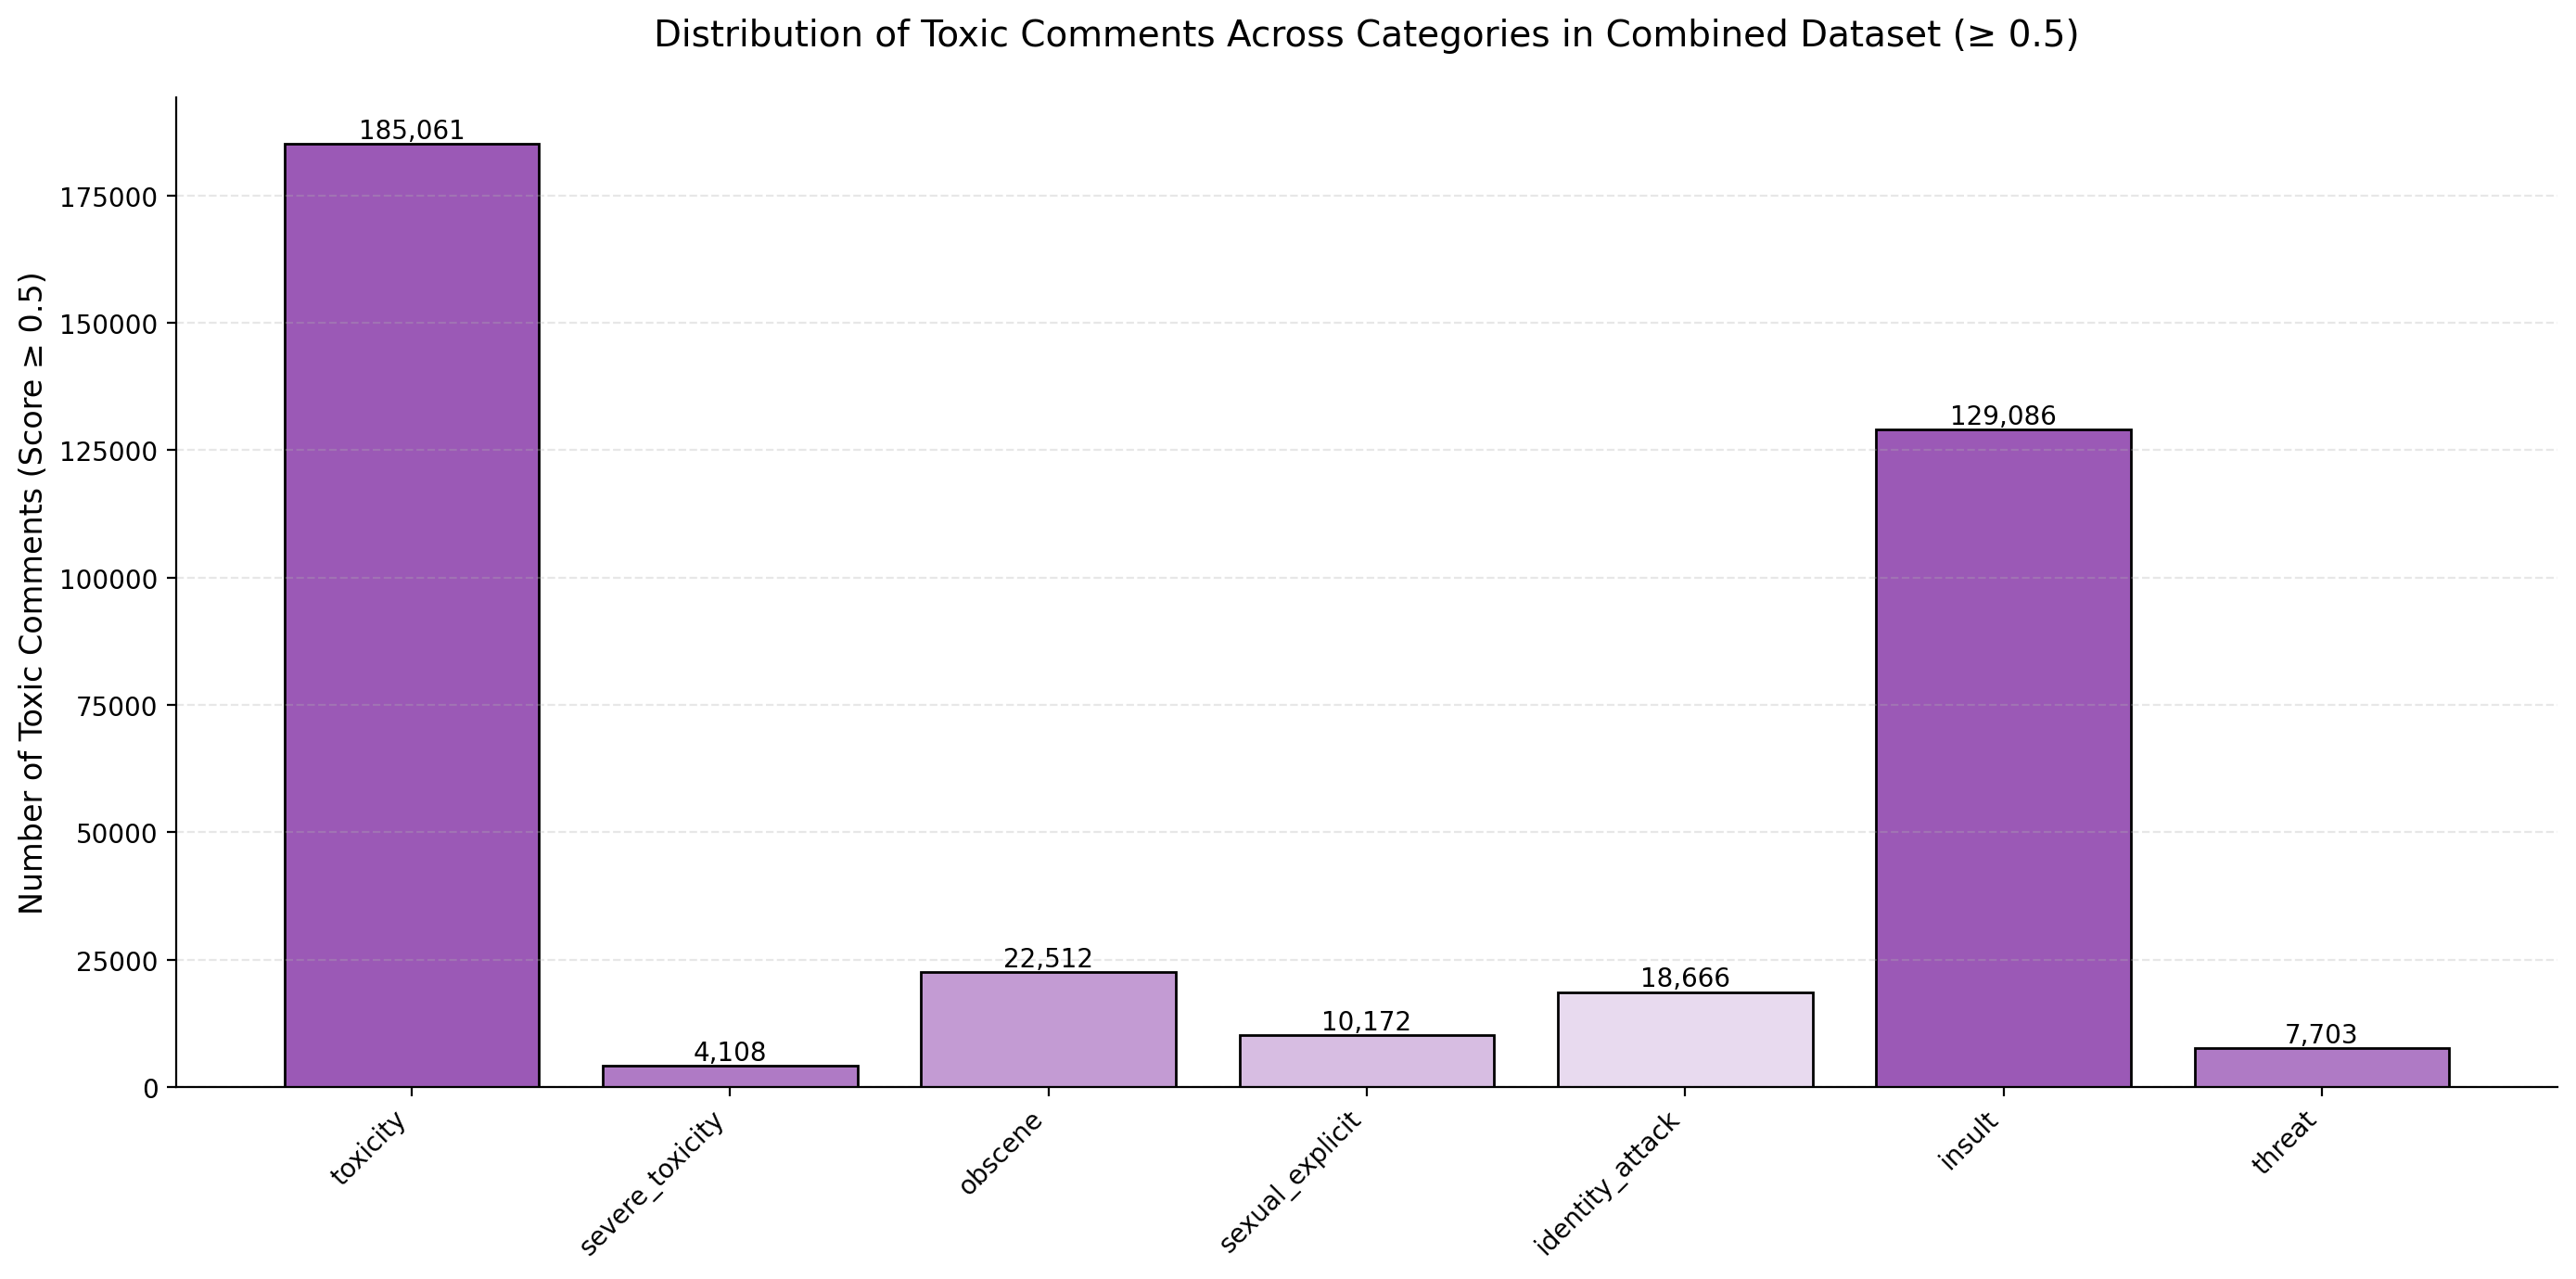

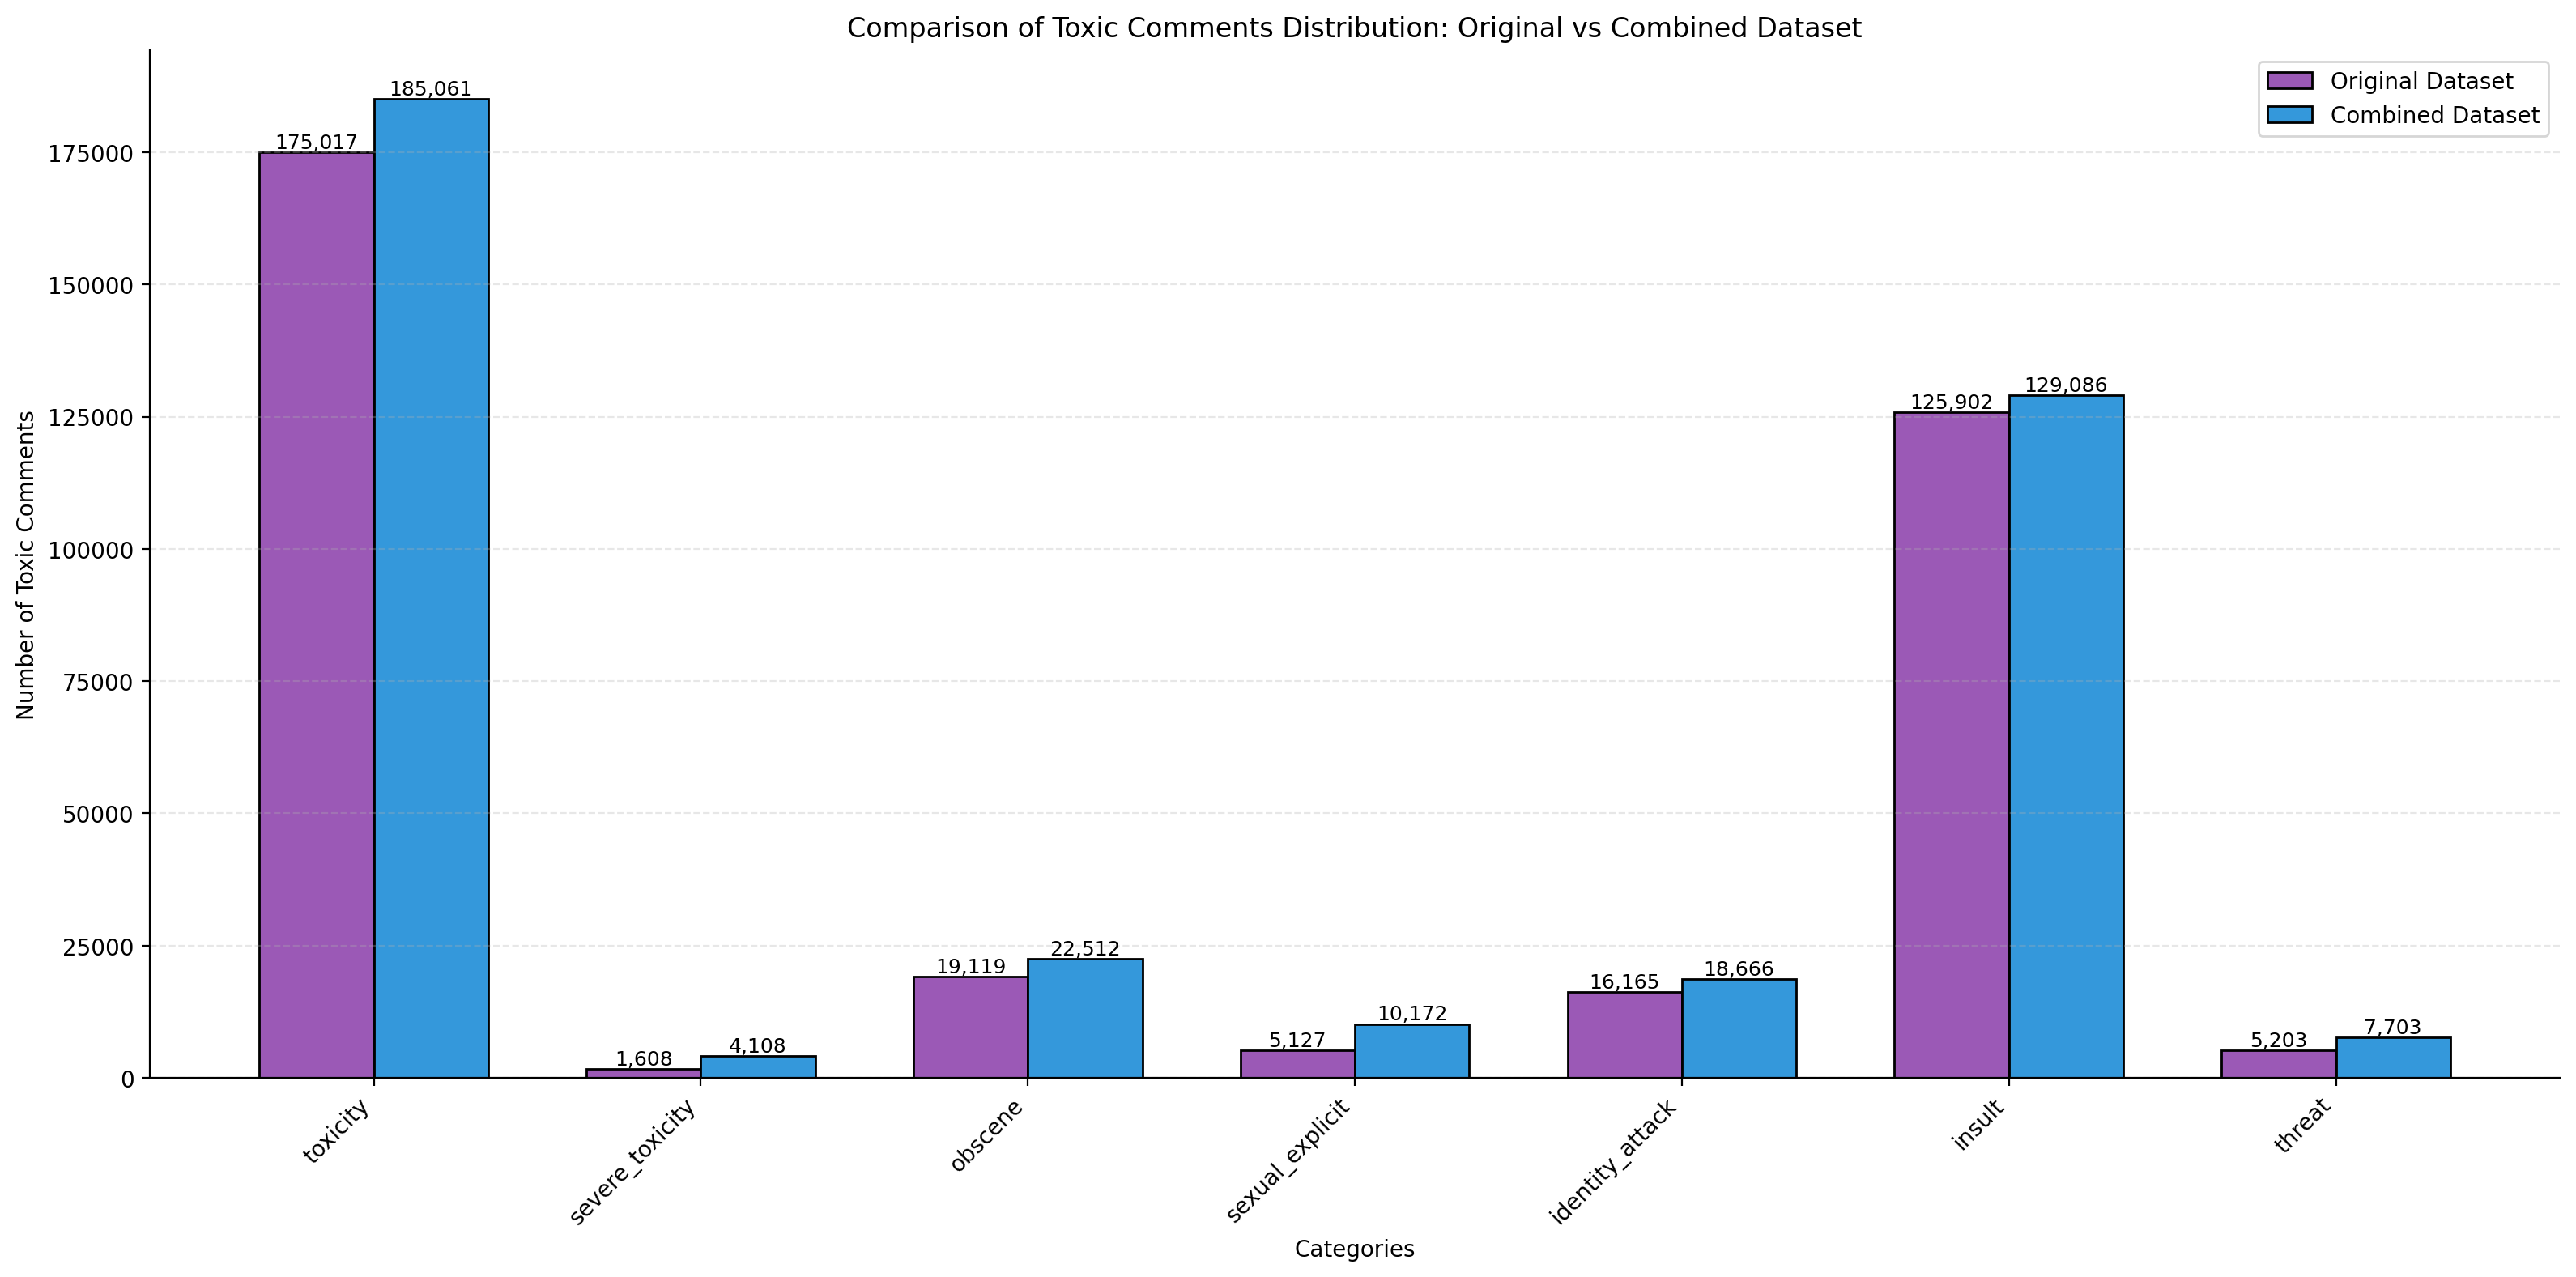

In [ ]:
# Define the purple color palette
purple_palette = ['#9b59b6', '#AF7AC5', '#C39BD3', '#D7BDE2', '#E8DAEF']

# Calculate counts for the original dataset
toxic_mask = (balanced_df[categories].ge(0.5).any(axis=1))
toxic_count = toxic_mask.sum()
non_toxic_count = len(balanced_df) - toxic_count

# Calculate counts for the combined dataset (original + synthetic)
toxic_mask_combined = (combined_labels.ge(0.5).any(axis=1))
toxic_count_combined = toxic_mask_combined.sum()
non_toxic_count_combined = len(combined_labels) - toxic_count_combined

# Create the comparison bar chart
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Original data distribution
original_data = [toxic_count, non_toxic_count]
ax[0].bar(['Toxic', 'Non-Toxic'], original_data, color=['#9b59b6', '#D7BDE2'])
ax[0].set_title('Undersampled Dataset')
ax[0].set_ylabel('Number of Comments')
ax[0].grid(True, axis='y', alpha=0.3)

# Add percentage labels
total_original = sum(original_data)
for i, v in enumerate(original_data):
    percentage = (v / total_original) * 100
    ax[0].text(i, v/2, f'{percentage:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    ax[0].text(i, v, f'{int(v):,}', ha='center', va='bottom')

# Combined data distribution
combined_data = [toxic_count_combined, non_toxic_count_combined]
ax[1].bar(['Toxic', 'Non-Toxic'], combined_data, color=['#9b59b6', '#D7BDE2'])
ax[1].set_title('Combined Dataset (Undersampled + Synthetic)')
ax[1].grid(True, axis='y', alpha=0.3)

# Add percentage labels
total_combined = sum(combined_data)
for i, v in enumerate(combined_data):
    percentage = (v / total_combined) * 100
    ax[1].text(i, v/2, f'{percentage:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    ax[1].text(i, v, f'{int(v):,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate counts for each category in the combined dataset
combined_toxic_counts = {}
for category in categories:
    combined_toxic_counts[category] = (combined_labels[category] >= 0.5).sum()
    
# Create bar plot for combined dataset categories
plt.figure(figsize=(14, 7))
bars = plt.bar(range(len(combined_toxic_counts)), list(combined_toxic_counts.values()), 
               color=[purple_palette[i % len(purple_palette)] for i in range(len(categories))], 
               edgecolor='black')

# Customize the plot
plt.xticks(range(len(combined_toxic_counts)), categories, rotation=45, ha='right')
plt.ylabel('Number of Toxic Comments (Score ≥ 0.5)', fontsize=12)
plt.title('Distribution of Toxic Comments Across Categories in Combined Dataset (≥ 0.5)', fontsize=14, pad=20)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Comparison chart between original and combined datasets for each category
plt.figure(figsize=(16, 8))

# Get original counts for each category
original_counts = []
for category in categories:
    original_counts.append((balanced_df[category] >= 0.5).sum())

# Prepare data for the plot
x = np.arange(len(categories))
width = 0.35

# Create the bars
bars1 = plt.bar(x - width/2, original_counts, width, label='Original Dataset', color='#9b59b6', edgecolor='black')
bars2 = plt.bar(x + width/2, list(combined_toxic_counts.values()), width, label='Combined Dataset', color='#3498db', edgecolor='black')

# Add labels, title and legend
plt.xlabel('Categories')
plt.ylabel('Number of Toxic Comments')
plt.title('Comparison of Toxic Comments Distribution: Original vs Combined Dataset')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()

# Add value labels on top of each bar
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)
             
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)

plt.grid(True, axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


In [ ]:
X_combined = np.vstack([embeddings, X_over.values])  # Both should be embedding vectors
y_combined = pd.concat([y_under, y_over], ignore_index=True) 

# Create a combined dataset with both embeddings and labels
combined_dataset = pd.DataFrame(X_combined)  

# Add the label columns
for col in y_combined.columns:
    combined_dataset[col] = y_combined[col].values

# Save the combined dataset
combined_dataset.to_csv('../data/merged_data/combined_dataset_with_synthetic.csv', index=False)

In [ ]:
print(f"NaN values in X: {np.isnan(X_combined).sum()}")
print(f"Infinity values in X: {np.isinf(X_combined).sum()}")
print(f"Min value in X: {np.min(X_combined)}")
print(f"Max value in X: {np.max(X_combined)}")

NaN values in X: 0
Infinity values in X: 0
Min value in X: -0.416830450296402
Max value in X: 0.4335273504257202
